In [ ]:
#setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import resample

In [ ]:
#make data to csv
import csv

dataset_path = 'dataset'  
csv_file_path = 'train.csv'

print("Original dataset :")
#write csv file
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    #row
    csv_writer.writerow(['name', 'status'])
    
    #join name with status
    for folder_name in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder_name)
        
        #check in folder
        if os.path.isdir(folder_path):
            #for file in folder
            for file_name in os.listdir(folder_path):
                #filename , status
                csv_writer.writerow([file_name, folder_name])
                
#readcsv status count
df = pd.read_csv(csv_file_path)
print(df['status'].value_counts())

# Balance the dataset
majority_class = df[df['status'] == df['status'].mode()[0]]
minority_class = df[df['status'] != df['status'].mode()[0]]
balanced_minority_class = resample(minority_class, 
                                   replace=True,    
                                   n_samples=len(majority_class), 
                                   random_state=42) 

# Combine the majority class with the balanced minority class
df_balanced = pd.concat([majority_class, balanced_minority_class])
# Shuffle the DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# Save the balanced DataFrame back to a CSV
df_balanced.to_csv(csv_file_path, index=False)

print("Balanced dataset :")
print(df_balanced['status'].value_counts())

Original dataset :
status
covid      671
healthy    618
Name: count, dtype: int64
Balanced dataset :
status
healthy    671
covid      671
Name: count, dtype: int64


C:\Users\Airpo\AppData\Local\Temp\ipykernel_67492\2826325990.py:15: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
C:\Users\Airpo\AppData\Local\Temp\ipykernel_67492\2826325990.py:15: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


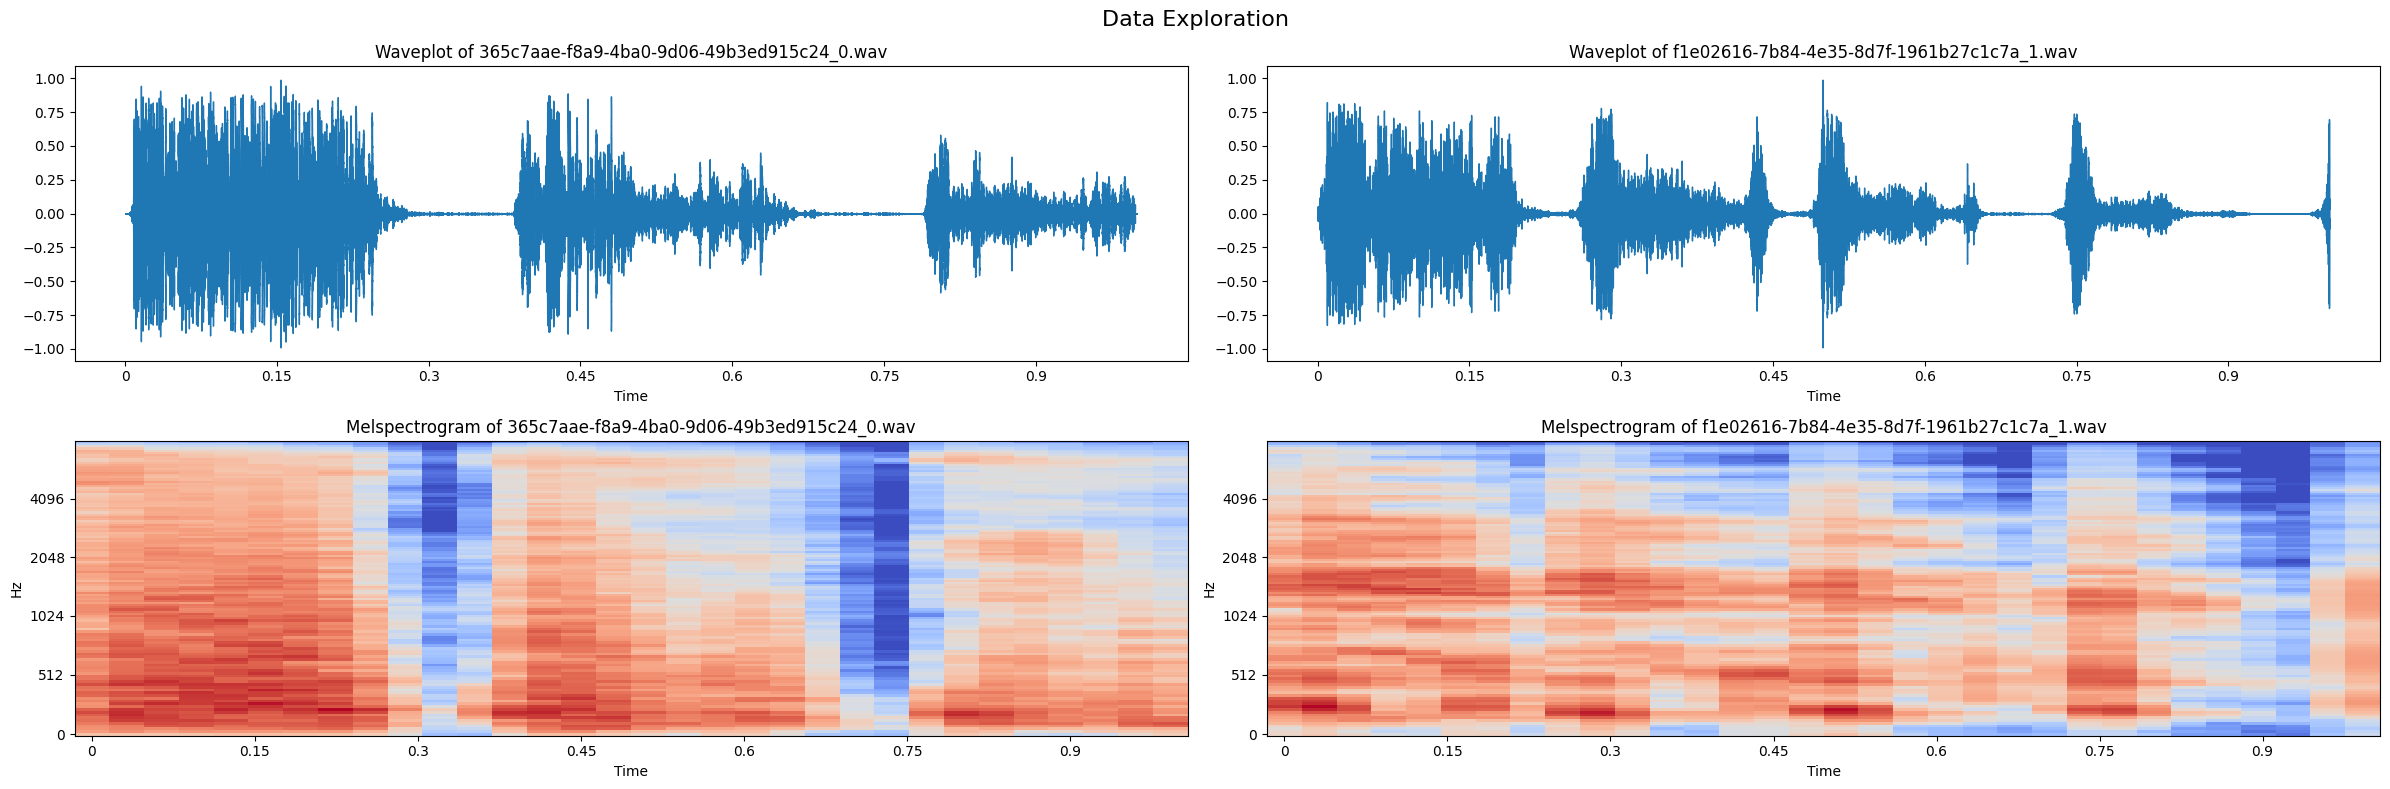

In [4]:
status = ["healthy", "covid"]

description = pd.read_csv('train.csv')

#subplots
fig, axs = plt.subplots(nrows=2, ncols=len(status))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)

for i, digit in enumerate(status):
    rand_file = np.random.choice(description[description['status'] == digit]['name'])
    
    audio, sr = librosa.load(os.path.join('dataset', digit, rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(status)])
    axs[i+len(status)].set(title=f'Melspectrogram of {rand_file}')

plt.tight_layout()
plt.show()

In [5]:
#Check file and convert to array
features = []
labels = []

for index, row in description.iterrows():
    file_path = os.path.join('dataset', row['status'], row['name'])
    
    # Check if file exists before loading
    if os.path.isfile(file_path):
        audio, sr = librosa.load(file_path, sr=None)
        mels_db = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
        mels_db = np.expand_dims(mels_db, axis=-1)  
        
        features.append(mels_db)
        labels.append(row['status'])
    else:
        print(f"File not found: {file_path}")

#Convert to array
features = np.array(features)
labels = np.array(labels)

#Result
if len(features) == 0:
    print("No audio features loaded. Please check your dataset paths.")
else:
    print(f"Loaded {len(features)} audio features.")

Loaded 1342 audio features.


In [6]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Check how many classes you have
num_classes = len(label_encoder.classes_)

# Adjust output layer size based on the number of classes
model = keras.Sequential(layers=[
    keras.layers.InputLayer(input_shape=(128, 32, 1)), 
    
    keras.layers.Conv2D(32, (3, 3), padding='same'), 
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, (3, 3), padding='same'), 
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(128, (3, 3), padding='same'), 
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), padding='same'), 
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(32, (3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),  # L2 Regularization
    keras.layers.Dropout(0.4),
    keras.layers.Dense(num_classes, activation='softmax')
])


# Set parameters for data splitting and training
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 300 

# One-hot encode labels; depth should match the number of classes
encoded_labels = label_encoder.fit_transform(labels).astype(np.int32)  # แปลงเป็น int32

# One-hot encoding labels
encoded_labels = tf.one_hot(indices=encoded_labels, depth=num_classes)

# Split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE, stratify=encoded_labels)


# Train the model with early stopping and model checkpoint
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('checkpoint_model.keras', save_best_only=True)
# Set up the learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, threshold=0.001)

model.compile(loss='categorical_crossentropy', optimizer='adamw', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 32, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 32, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 4, 64)      │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 2, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 2, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 194,594 (760.13 KB)

 Trainable params: 193,954 (757.63 KB)

 Non-trainable params: 640 (2.50 KB)

In [7]:
class_weights = {}
#หาค่าเพื่อ balance class ด้วย class_weights
for i in range(num_classes):
    class_weights[i] = len(y_train) / (num_classes * np.sum(y_train[:, i]))
print(class_weights)

{0: np.float32(0.9990689), 1: np.float32(1.0009328)}


In [ ]:
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])

axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


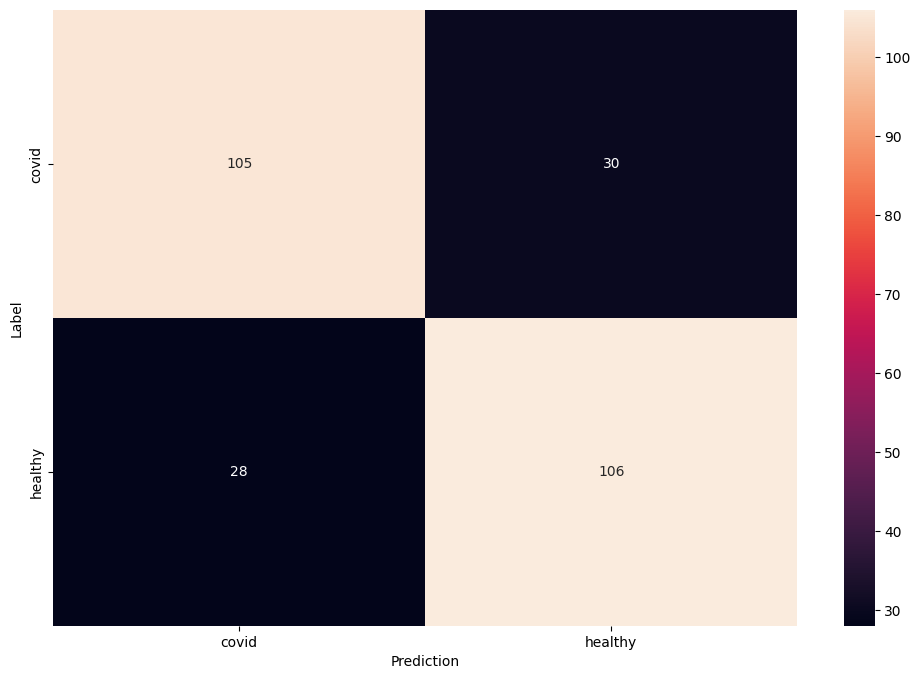

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [9]:
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


NameError: name 'classification_report' is not defined

In [ ]:
from sklearn.metrics import classification_report
model = tf.keras.models.load_model('best_model3.keras')
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       135
           1       0.84      0.84      0.84       134

    accuracy                           0.84       269
   macro avg       0.84      0.84      0.84       269
weighted avg       0.84      0.84      0.84       269



9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


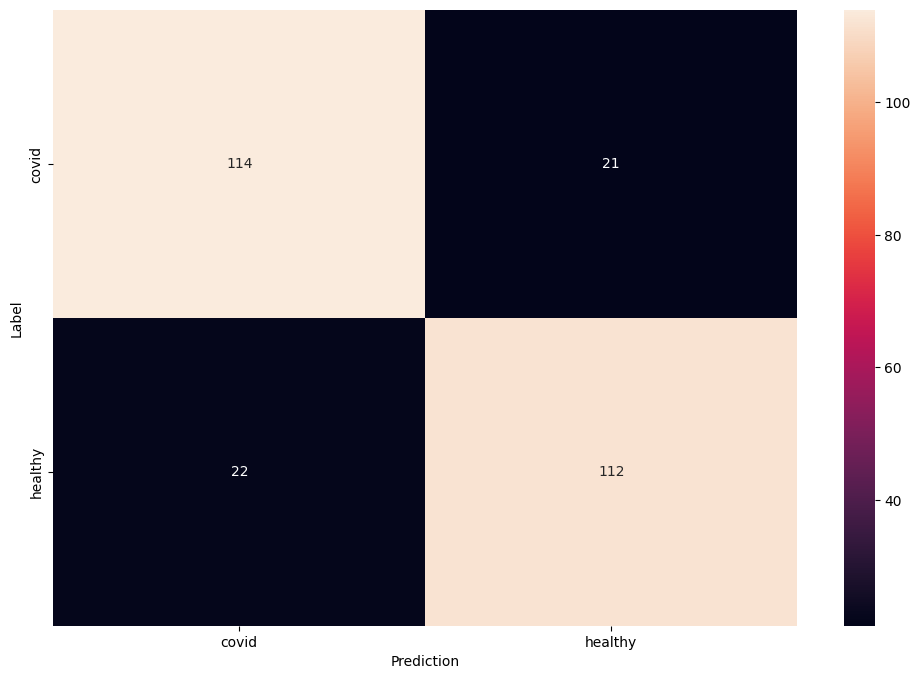

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
#Save the trained model
#model.save('best_model4.keras')

In [ ]:
#test
import librosa
import numpy as np

audio_path = r'dataset\healthy\0add5e55-136a-4eaa-98db-3495635cbb56_0.wav'  # 
audio, sr = librosa.load(audio_path, sr=None)

mels_db = librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)

mels_db = np.expand_dims(mels_db, axis=-1) 
mels_db = np.expand_dims(mels_db, axis=0) 

predictions = model.predict(mels_db)

predicted_class = np.argmax(predictions, axis=1)  

status_labels = label_encoder.classes_ 
predicted_label = status_labels[predicted_class[0]]
print(f"ผลการทำนาย: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
ผลการทำนาย: healthy
